## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import torchvision
import ssim

import shiftpatch_module as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223





### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 2
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**8
    ,batchSplit = 2**1
    ,loaderWorkers = 16
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 1e-4
    ,learningRateG = 1e-4
)

sg.DCfg = sg.DCfgClass()


### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.samplingMask = sg.SamplingMask()
sg.samplingVari = sg.SamplingVariations()
sg.trainSet = sg.createTrainSet()
sg.testSet = sg.createTestSet()
sg.testLoader = sg.createDataLoader(sg.createSubSet(sg.testSet),
                                    num_workers=sg.TCfg.loaderWorkers)
sg.refImages, sg.refNoises = sg.createReferences(0)

### <font style="color:lightblue">Show</font>

(1, 615, 127, 1241)


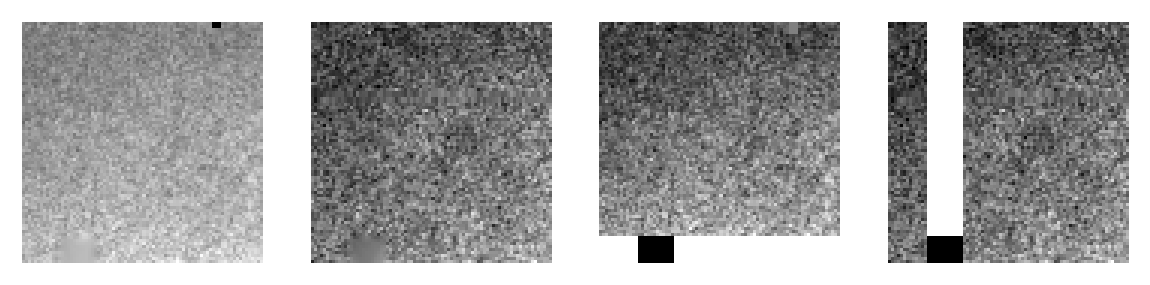

In [5]:

sg.showMe(sg.testSet)

## <font style="color:lightblue">Models</font>

In [6]:
sg.batchNormOpt = { #"track_running_stats" : False,
                    #"momentum" : 0.5,
                  }

### <font style="color:lightblue">Generator</font>

In [7]:
save_interim = False
class Generator(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator, self).__init__(latentChannels=1, inputChannels=2)
        self.amplitude = 1
        self.baseChannels = 16

        self.noise2latent = self.createLatent()

        self.encoders =  nn.ModuleList([
            self.encblock( (self.inputChannels+abs(self.latentChannels)) /self.baseChannels,
                               1, 3, norm=False,),
            self.encblock( 1,  1, 3, norm=True, dopadding=True),
            self.encblock( 1,  2, 3, norm=True, stride=2),
            self.encblock( 2,  2, 3, norm=True, dopadding=True),
            self.encblock( 2,  4, 3, norm=True, stride=2),
            self.encblock( 4,  4, 3, norm=True, dopadding=True),
            self.encblock( 4,  8, 3, norm=True, stride=2),
            self.encblock( 8,  8, 3, norm=True, dopadding=True),
            self.encblock( 8, 16, 3, norm=True, stride=2),
            self.encblock(16, 16, 3, norm=True, dopadding=True),
            ])

        self.fcLink = self.createFClink()

        self.decoders = nn.ModuleList([
            self.decblock(32, 16, 3, norm=True, dopadding=True),
            self.decblock(32,  8, 4, norm=True, stride=2),
            self.decblock(16,  8, 3, norm=True, dopadding=True),
            self.decblock(16,  4, 4, norm=True, stride=2),
            self.decblock( 8,  4, 3, norm=True, dopadding=True),
            self.decblock( 8,  2, 4, norm=True, stride=2),
            self.decblock( 4,  2, 3, norm=True, dopadding=True),
            self.decblock( 4,  1, 4, norm=True, stride=2),
            self.decblock( 2,  1, 3, norm=True, dopadding=True),
            self.decblock( 2,  1, 3, norm=False),
            ])

        self.lastTouch = self.createLastTouch()

        #sg.load_model(self, model_path="good_0_gen.pt" )


sg.generator = Generator().to(sg.TCfg.device)
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0,1],0:4,...], sg.refNoises[[0,1],...]] ] ).__str__()
#print(model_summary)

#checkPoint = torch.load("saves/mssim_mili/checkPoint.pth", map_location=sg.TCfg.device, weights_only=False)
#sg.optimizer_G.load_state_dict(checkPoint['optimizerGen'])
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()


#_ = sg.testMe(sg.refImages)

### <font style="color:lightblue">Discriminator</font>

In [8]:
sg.discriminatePair = True
class DiscriminatorIMG(sg.DiscriminatorTemplate):
    def __init__(self):
        super(DiscriminatorIMG, self).__init__()
        self.baseChannels = 16
        self.body =  nn.Sequential(
            self.encblock( 2/self.baseChannels,
                               1, 3, norm=False,),
            self.encblock( 1,  1, 3, norm=False, dopadding=True),
            self.encblock( 1,  2, 3, norm=False, stride=2),
            self.encblock( 2,  2, 3, norm=False, dopadding=True),
            self.encblock( 2,  4, 3, norm=False, stride=2),
            self.encblock( 4,  4, 3, norm=False, dopadding=True),
            self.encblock( 4,  8, 3, norm=False, stride=2),
            self.encblock( 8,  8, 3, norm=False, dopadding=True),
            self.encblock( 8, 16, 3, norm=False, stride=2),
            self.encblock(16, 16, 3, norm=False, dopadding=True),
            )
        self.head = self.createHead()
        #sg.load_model(self, model_path="saves/msssim1_noFFT/model_dis.pt" )


fftNorm = torch.tensor(sg.loadImage("NormFFT.tif"), device=sg.TCfg.device)[None,None,...]

class DiscriminatorFFT(sg.DiscriminatorTemplate):

    def __init__(self):
        super(DiscriminatorFFT, self).__init__()
        self.baseChannels = 16
        self.chIn = 2
        self.body =  nn.Sequential(
            self.encblock( self.chIn/self.baseChannels,
                               1, 3, norm=False,),
            self.encblock( 1,  1, 3, norm=False, dopadding=True),
            self.encblock( 1,  2, 3, norm=False, stride=2),
            self.encblock( 2,  2, 3, norm=False, dopadding=True),
            self.encblock( 2,  4, 3, norm=False, stride=2),
            self.encblock( 4,  4, 3, norm=False, dopadding=True),
            self.encblock( 4,  8, 3, norm=False, stride=2),
            self.encblock( 8,  8, 3, norm=False, dopadding=True),
            self.encblock( 8, 16, 3, norm=False, stride=2),
            self.encblock(16, 16, 3, norm=False, dopadding=True),
            )
        self.head = self.createHead()
        #sg.load_model(self, model_path="/data/anton/shiftpatch/model_dis_fft.pt" )

    def forward(self, images):
        if images.dim() == 3:
            images = images.unsqueeze(1)
        fftIO = images[:,[0],...] + 1j * images[:,[1],...]
        fftIO = torch.fft.fft2(fftIO, norm="forward") / fftNorm
        modelIn = torch.concat( (fftIO.real, fftIO.imag), dim=1 )
        convRes = self.body(modelIn)
        res = self.head(convRes)
        return res


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discIMG = DiscriminatorIMG()
        self.discFFT = DiscriminatorFFT()
        self.IMG_FFT = 0.5
        sg.load_model(self, model_path="good_0_dis.pt" )
    def forward(self, images):
        if images.dim() == 3:
            images = images.unsqueeze(1)
        resIMG = self.discIMG(images) if self.IMG_FFT > 0 else 0
        resFFT = self.discFFT(images) if self.IMG_FFT < 1 else 0
        res = self.IMG_FFT * resIMG + (1-self.IMG_FFT) * resFFT
        #print(resIMG, resFFT)
        return res


sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[[0],0:2,...] ).__str__()
#print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 1).step()



/home/user/usr/src/shiftpatch/shiftpatch_module.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=TCfg.device))

## Loss

In [9]:
sg.noAdv = False
sg.MSSSIM = ssim.MS_SSIM(data_range=2.0, size_average=False, channel=1, win_size=1)
#sg.normTestRec, sg.normTestMSE, sg.normTestL1L = sg.summarizeSet(sg.testLoader)[0:3]
#print(f"{sg.normTestRec:.3e}, {sg.normTestMSE:.3e}, {sg.normTestL1L:.3e}")
#sg.normRec, sg.normMSE, sg.normL1L = sg.summarizeSet(
#                                            sg.createDataLoader(
#                                                sg.createSubSet(sg.trainSet),
#                                                num_workers=sg.TCfg.loaderWorkers))[0:3]
#print(f"{sg.normRec:.3e}, {sg.normMSE:.3e}, {sg.normL1L:.3e}")

#sg.normTestRec, sg.normTestMSE, sg.normTestL1L =  3.185e-03, 3.845e-04, 6.890e-03 # 8.905e-05, 4.314e-04, 7.362e-03
#sg.normRec, sg.normMSE, sg.normL1L = 1.443e-02, 2.267e-03, 1.797e-02 # 1.170e-04, 1.915e-03, 1.639e-02
sg.normTestRec, sg.normTestMSE, sg.normTestL1L = 5.100e-05, 3.864e-04, 6.929e-03
sg.normRec, sg.normMSE, sg.normL1L = 6.128e-05, 1.838e-03, 1.604e-02


# SSIM:   bs0 4.463e-02, 1.044e-02 # bsMean 4.503e-02, 1.025e-02 # bs- 4.448e-02, 1.028e-02 # mskMean 4.739e-02, 1.078e-02
# MSSSIM: bs0 1.431e-02, 3.716e-03 # bsMean 1.443e-02, 3.185e-03 # bs- 1.354e-02, 3.096e-03



## <font style="color:lightblue">Restore checkpoint</font>

In [11]:
sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minRecTest, sg.minRecTrain, sg.minTestEpoch, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
sg.writer = sg.createWriter(sg.TCfg.logDir, True)

sg.scheduler_G.gamma = 1-0.002
sg.scheduler_D.gamma = 1-0.002
#sg.optimizer_G.step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 0.1).step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.1).step()

#sg.startFrom = 0
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0

#sg.epoch = 0
#sg.imer = 0
#sg.optimizer_G.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 1).step()
print(f"Initial LR :{sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG} {sg.epoch} {sg.imer}")

Initial LR :0.1 11 33839104


## Test me

Losses: Rec 3.294e-06, MSE 7.552e-04, L1L 1.073e-02, Dis: 0.645256 (0.516), Adv: 1.202 (0.337), Gen: 3.512e-06, Pixels: 10912.0.


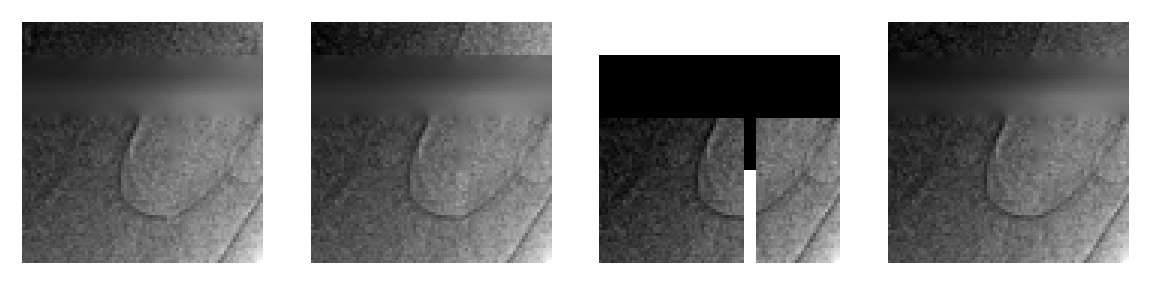

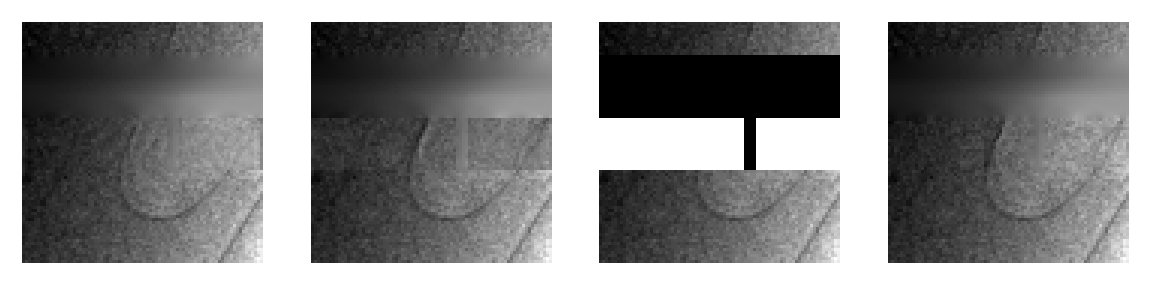

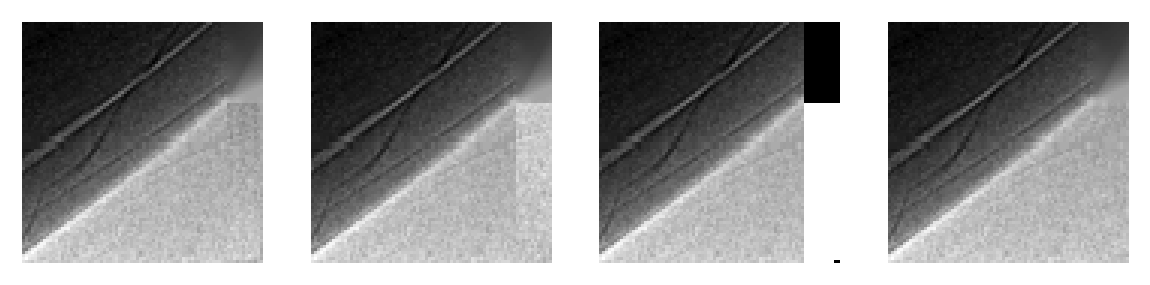

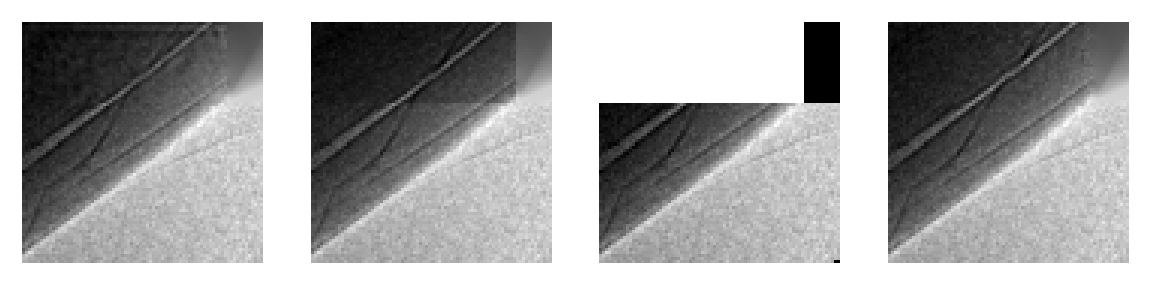

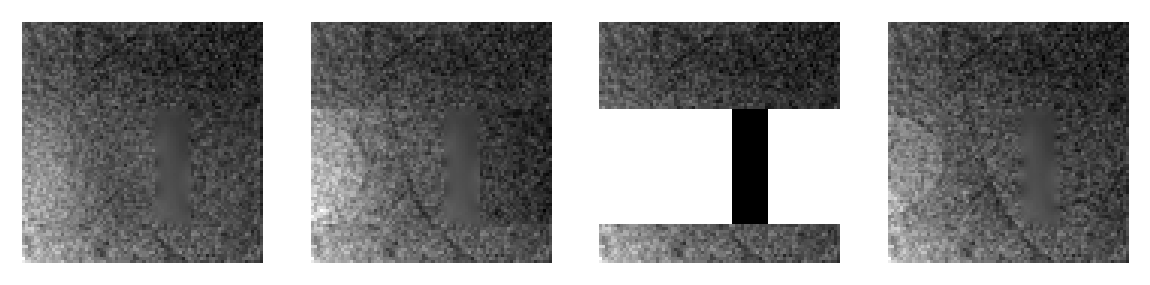

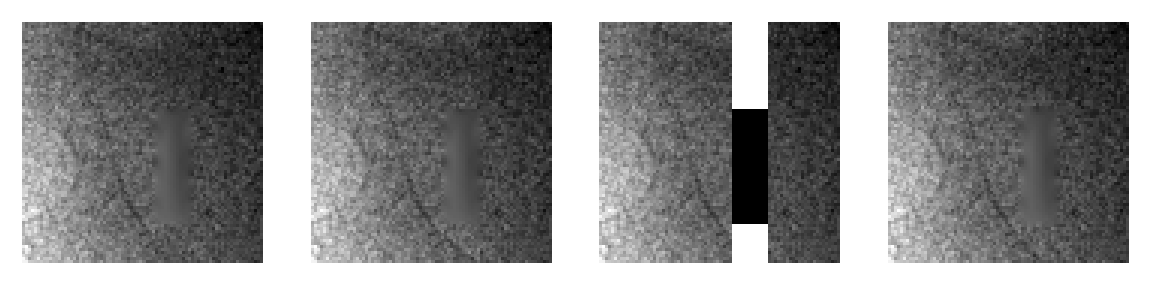

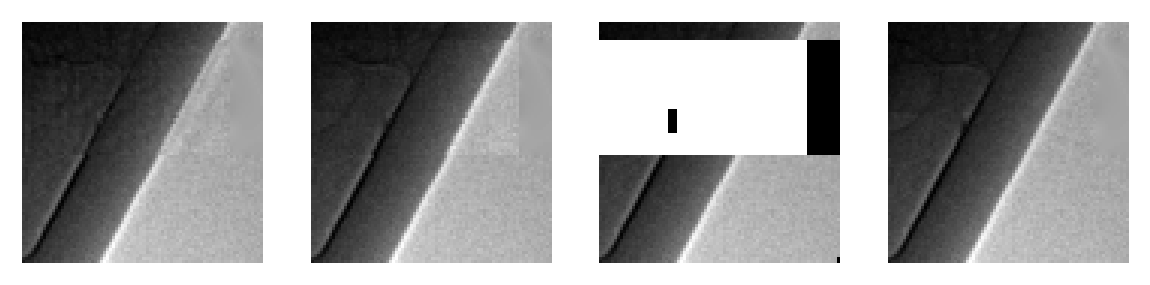

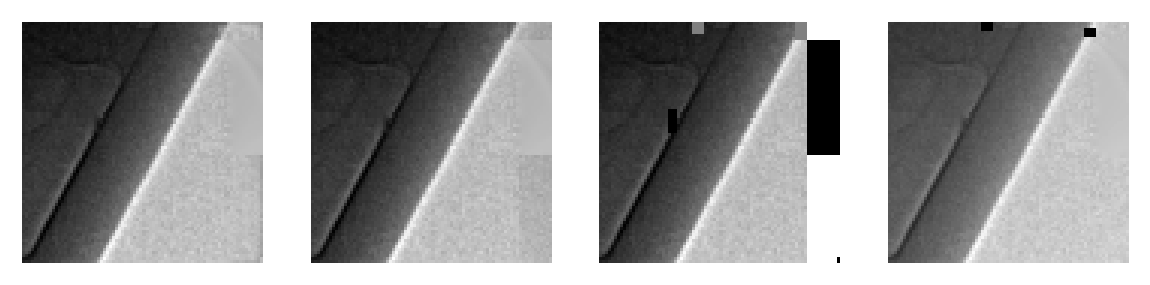

In [12]:
#sg.load_model(sg.discriminator, model_path="model_0_dis.pt" )

_ = sg.testMe(sg.refImages)


## <font style="color:lightblue">Execute</font>

In [13]:
sg.freeGPUmem()

Epoch:  17 (  2). (Train: 0.241/0.241, Test: 0.352/0.245).
Update (1.0e+00/3.2e-01).                Dis: 0.601 (0.596)  Adv: 0.961 (0.401)  Gen: 0.361  Rec: 0.240 
Random image (1, 1006, 130, 1692).       Dis: 0.576 (0.541)  Adv: 0.930 (0.375)  Gen: 0.146  Rec: 0.010 
Reference images.                        Dis: 0.629 (0.574)  Adv: 1.038 (0.395)  Gen: 0.195  Rec: 0.044 


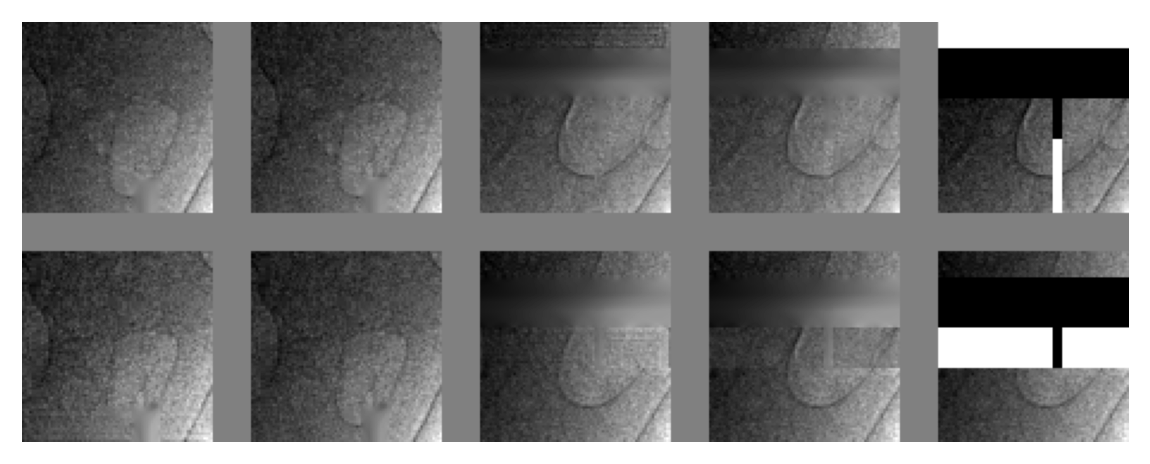

  4%|▍         | 483/12016 [03:24<1:21:24,  2.36it/s]


KeyboardInterrupt: 

In [ ]:
#torch.autograd.set_detect_anomaly(True)


#sg.minRecTest, sg.minRecTrain = 1, 1
sg.ADV_DIF = 1e-5 # 0.008108
sg.trainCyclesGen = 1
sg.trainCyclesDis = 1
sg.SSIM_MSE = 1 - 1e-3



skipThresholdGen = 0.02
def my_trainGen(subPred_fake, subPred_real) :
    #return True
    return not sg.skipGen and ( subPred_fake.mean() < 0.5 - skipThresholdGen and \
                                subPred_real.mean() > 0.5 + skipThresholdGen )
sg.trainGen = my_trainGen

skipThresholdDis = 0.02
def my_trainDis(subPred_fake, subPred_real) :
    #return True
    return not sg.skipDis and ( subPred_fake.mean() > sg.TCfg.labelSmoothFac + skipThresholdDis and \
                                subPred_real.mean() < 1- sg.TCfg.labelSmoothFac - skipThresholdDis )
sg.trainDis = my_trainDis

def adjustScheduler(scheduler, iniLr, target) :
    if scheduler is None :
        return ""
    gamma = scheduler.gamma
    curLR = scheduler.get_last_lr()[0] / iniLr
    if gamma < 1 and curLR > target \
    or gamma > 1 and curLR < target :
        scheduler.step()
    return f"LR : {curLR:.2e}. "

import os
def my_beforeReport(sglocals) :
    message = ""
    with open(f"message_{sg.TCfg.exec}.txt", 'a') as file:
        file.write(message + "\n")
    print(message)
#sg.beforeReport = my_beforeReport


#sg.TCfg.loaderWorkers = 0 # for debug single threaded
try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoaderrelo
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise

# from scratch
# ADV_DIFF = 1e-5, LR = 0.1, SSIM_MSE = 1-1e-2
# SSIM_MSE 1-1e-2 => 1-1e-3 (e)


## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()